<a href="https://colab.research.google.com/github/e-mags/ECE1512_Project_A/blob/main/HMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(r'/content/drive/MyDrive/ColabNotebooks/project_a_supp')  # Change the directory to torchRay-master folder

# Requirements

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [5]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/project_a_supp/hmt_dataset/HMT_train'
test_dir = '/content/drive/MyDrive/ColabNotebooks/project_a_supp/hmt_dataset/HMT_test'

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [6]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [8]:
model=load_model('models/HMT.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

In [9]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Text(0.5, 1.0, 'Training progress: Accuracy')

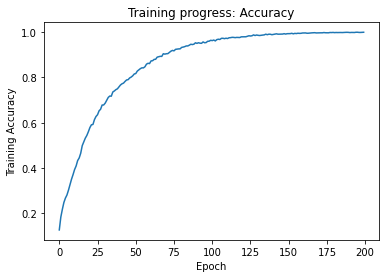

In [10]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

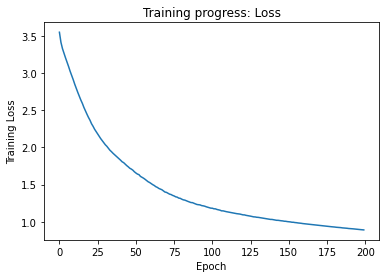

In [11]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

Load the explaier library

In [12]:
from xai_utils import *

Load a batch of images

In [13]:
test_generator.reset()

In [14]:
image_batch,label_batch=test_generator.next()

Classes:

In [15]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [16]:
index=np.random.randint(0,len(image_batch))
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.9999262


In [17]:
print(np.argmax(label_batch,axis=1))

[6 2 3 2 0 2 0 1 4 1 1 7 7 1 3 1 3 0 3 0 7 5 0 1 6 4 6 7 3 0 4 1]


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [18]:
layers=[['conv2d_3']]

In [19]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 423 ms, sys: 330 ms, total: 752 ms
Wall time: 772 ms


## Grad-CAM (Gradient-based Class Activation Mapping)

In [20]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 166 ms, sys: 40.5 ms, total: 206 ms
Wall time: 299 ms


## RISE (Randomized Input Sampling for Explanation)

In [21]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 1.71 s, sys: 704 ms, total: 2.41 s
Wall time: 2.3 s


## Plot the results

In [23]:
from scipy import stats
def plot_maps(maps,n_maps):
  size_x = np.int(np.floor(np.sqrt(n_maps)))
  size_y = np.int(np.ceil(n_maps/size_x))
  ix = 1
  plt.figure(figsize=[12,12])
  for _ in range(size_x):
    for _ in range(size_y):
      ax = plt.subplot(size_x,size_y,ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(maps[:,:,ix-1],cmap='gray')
      ix += 1

def plot_feature_map(input_model,image,layer_name,n_maps):
  target_layer = input_model.get_layer(layer_name)
  model = keras.Model([input_model.input],[target_layer.output])
  maps = model.predict(image)
  #n_maps = target_layer.get_config()['filters']
  plot_maps(maps[0,:,:,:],n_maps)
def plot_kde(map,cov):
  density = stats.gaussian_kde(map.flatten())
  density.covariance_factor = lambda : cov
  density._compute_covariance()
  x = np.linspace(np.min(map),np.max(map),200)
  plt.figure()
  plt.plot(x,density(x))
model.summary()
#plot_feature_map(model,np.expand_dims(image_batch[index],axis=0),'max_pooling2d_1',64)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.97743416


Text(0.5, 1.0, 'Remaining Grad-CAM')

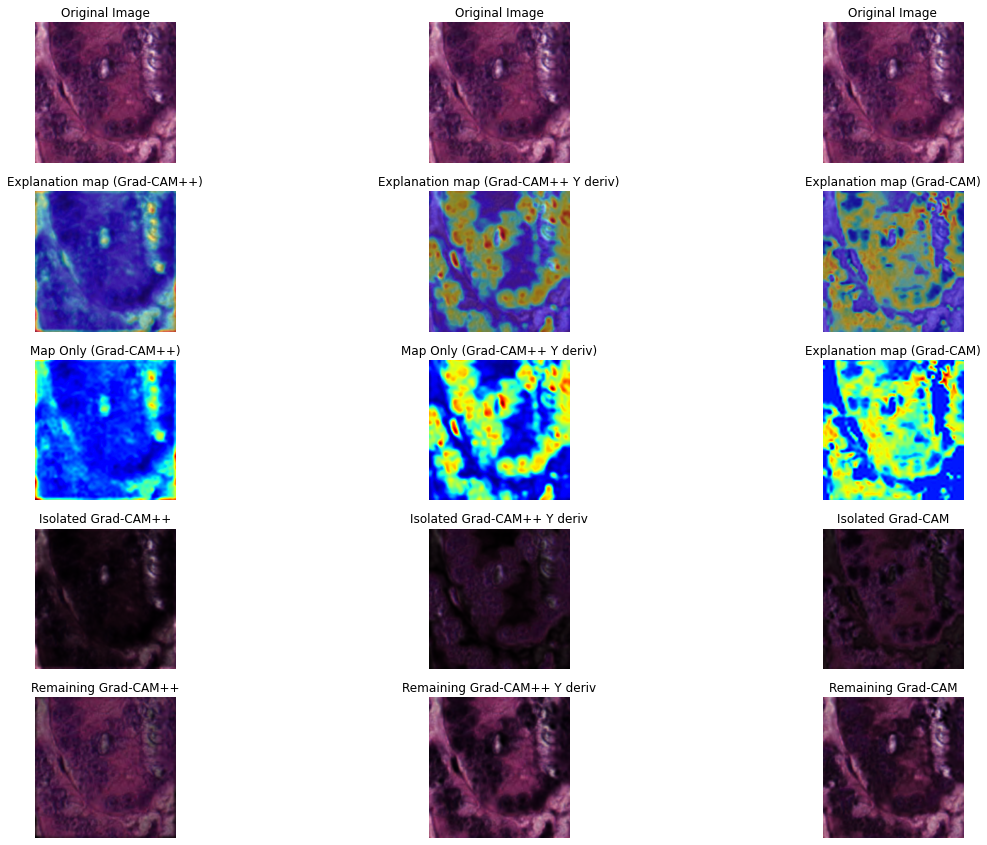

In [28]:
#@title Grad-CAM++

index=np.random.randint(0,len(image_batch))
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

import keras.layers.core

def grad_cam_pp_ygrad(input_model,image,layer_name):
  cls = np.argmax(input_model.predict(image))

  y_c = input_model.output
  conv_output = input_model.get_layer(layer_name).output
  feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
  with tf.GradientTape(persistent=True) as tape3:
    with tf.GradientTape() as tape2:
      with tf.GradientTape() as tape1:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
      grads_val = tape1.gradient(loss, all_fmap_masks)
    second_grads = tape2.gradient(grads_val,all_fmap_masks)
  third_grads = tape3.gradient(second_grads,all_fmap_masks)
  if len(image.shape)==3:
      axis=(0, 1)
  elif len(image.shape)==4:
      axis=(0, 1, 2)
  
  weights = tf.maximum(grads_val, 0.0)

  # Calculate alpha
  global_sum = np.expand_dims(np.sum(all_fmap_masks,axis=axis),axis=axis)
  alpha_num = second_grads
  alpha_denom = 2.0 * second_grads + global_sum*third_grads
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
  alpha = alpha_num / alpha_denom

  # Normalize alpha
  alpha_thresh = np.where(weights,alpha, 0.0)
  alpha_norm_const = np.sum(alpha_thresh, axis=axis)
  alpha_norm_const_actual = np.where(alpha_norm_const != 0.0, alpha_norm_const, np.ones(alpha_norm_const.shape))
  alpha /= np.expand_dims(alpha_norm_const_actual, axis=axis)

  # Calculate weights
  weights = np.sum(weights * alpha, axis=axis)

  cam = np.dot(all_fmap_masks[0], weights)

  H,W= image.shape[1:3]
  cam = np.maximum(cam, 0)
  cam /= np.max(cam)

  cam = zoom(cam,H/cam.shape[0])
  cam = np.maximum(cam, 0)
  cam = cam / cam.max()
  return cam

def grad_cam_pp_sgrad(input_model,image,layer_name):
  #input_model = model
  #image = np.expand_dims(image_batch[index],axis=0)
  #layer_name = 'max_pooling2d_1'
  cls_probs = input_model.predict(image)
  cls = np.argmax(cls_probs)
  n_cls = cls_probs.shape[1]

  clone = keras.models.clone_model(input_model)

  """GradCAM method for visualizing input saliency."""
  # set last layer activation to linear to expose s_c
  clone.layers[-1].activation = keras.activations.linear
  s_c = clone.layers[-1].output

  # add softmax as another layer
  y_c = keras.layers.Activation('softmax')(s_c)
  conv_output = clone.get_layer(layer_name).output
  feedforward1 = keras.models.Model([clone.input], [conv_output,s_c, y_c])
  #feedforward1.summary()
  s_k = {}
  y_k = {}
  with tf.GradientTape(persistent=True) as tape:
    ff_results=feedforward1([image])
    all_fmap_masks, s, y = ff_results[0], ff_results[1], ff_results[2]
    for k in range(n_cls):
      s_k[k] = s[:,k]
      y_k[k] = y[:,k]

  # Calculate dyc_da
  dsk_da = {}
  # Calculate sum terms and gradient
  for k in range(n_cls):
    dsk_da[k] = tape.gradient(s_k[k],all_fmap_masks)
    
    if k == 0:
      k_sum = y_k[k] * dsk_da[k]
    else:
      k_sum += y_k[k] * dsk_da[k]

  # Calculate dyc_da term
  dyk_da = {}
  for k in range(n_cls):
    dyk_da[k] = y_k[k] * (dsk_da[k] - k_sum)

  dyc_da = dyk_da[cls]

  # Calculate terms for d2yk_da2
  for k in range(n_cls):
    if k == 0:
      dyksk_da_sum = dyk_da[k] * dsk_da[k]
    else:
      dyksk_da_sum += dyk_da[k] * dsk_da[k]

  d2yk_da2 = {}
  # Calculate d2yk_da2
  for k in range(n_cls):
    d2yk_da2[k] = dyk_da[k] * (dsk_da[k] - k_sum) - y_k[k] * dyksk_da_sum

  d2yc_da2 = d2yk_da2[cls]

  # Calculate terms for d3yk_da3
  for k in range(n_cls):
    if k == 0:
      d2yksk_da2_sum = d2yk_da2[k] * dsk_da[k]

  # Calculate d3yk_da3
  d3yk_da3 = {}
  for k in range(n_cls):
    d3yk_da3[k] = d2yk_da2[k] * (dsk_da[k] - k_sum) - 2 * dyk_da[k] * (dyksk_da_sum) - y_k[k]*(d2yksk_da2_sum)

  d3yc_da3 = d3yk_da3[cls]

  # Calculate 
  if len(image.shape)==3:
      axis=(0, 1)
  elif len(image.shape)==4:
      axis=(0, 1, 2)

  global_sum = np.expand_dims(np.sum(all_fmap_masks,axis=axis),axis=(0,1,2))
  alpha_num = d2yc_da2
  alpha_denom = 2.0*d2yc_da2 + global_sum*d3yc_da3
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
  alpha = alpha_num / alpha_denom

  # alpha normalization https://github.com/adityac94/Grad_CAM_plus_plus/blob/master/misc/utils.py

  weights = tf.maximum(dyc_da,0.0) # ReLU
  alpha_thresh = np.where(weights,alpha, 0.0)
  alpha_norm_const = np.sum(alpha_thresh,axis=axis)
  alpha_norm_const_actual = np.where(alpha_norm_const != 0.0, alpha_norm_const,np.ones(alpha_norm_const.shape))
  alpha /= np.expand_dims(alpha_norm_const_actual,axis=axis)

  # Calculate weights
  weights = np.sum(weights*alpha,axis=axis)
  #weights = np.sum(tf.nn.relu(dyc_da)*alpha_num/alpha_denom, axis=axis)
  #plot_maps(tf.nn.relu(dyc_da[0,:,:]),n_cls)
  #plot_kde(weights,0.25)
  #plot_kde(tf.nn.relu(dyc_da[0,:,:]).numpy(),0.25)
  #plot_kde(alpha_denom,0.25)
  #plot_kde(alpha_num.numpy(),0.25)
  cam = np.dot(all_fmap_masks[0], weights)
  #print (cam)
  H,W= image.shape[1:3]
  cam = np.maximum(cam, 0)
  cam /= np.max(cam)
  #cam = resize(cam, (H, W))
  cam = zoom(cam,H/cam.shape[0])
  cam = np.maximum(cam, 0)
  cam = cam / cam.max()
  return cam
conv_layer = 'max_pooling2d_1'
#map_gradcampp = cam
map_gradcampp = grad_cam_pp_sgrad(model,np.expand_dims(image_batch[index],axis=0),conv_layer)
map_gradcampp -= map_gradcampp.min()
map_gradcampp /= map_gradcampp.max() + np.finfo(np.double).eps
plt.figure(figsize=[20,15])
rows = 5
cols = 3

rowcol = (0,0)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Original Image')

rowcol = (1,0)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(image_batch[index])
m1 = plt.imshow(map_gradcampp, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM++)')

rowcol = (2,0)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
m2 = plt.imshow(map_gradcampp, cmap='jet')
plt.axis('off')
plt.title('Map Only (Grad-CAM++)')

rowcol = (3,0)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(np.expand_dims(map_gradcampp,axis=2)*image_batch[index])
plt.axis('off')
plt.title('Isolated Grad-CAM++')

rowcol = (4,0)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow((1-np.expand_dims(map_gradcampp,axis=2))*image_batch[index])
plt.axis('off')
plt.title('Remaining Grad-CAM++')

map_gradcampp_ygrad = grad_cam_pp_ygrad(model,np.expand_dims(image_batch[index],axis=0),conv_layer)
map_gradcampp_ygrad -= map_gradcampp_ygrad.min()
map_gradcampp_ygrad /= map_gradcampp_ygrad.max() + np.finfo(np.double).eps

rowcol = (0,1)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Original Image')

rowcol = (1,1)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(image_batch[index])
m1 = plt.imshow(map_gradcampp_ygrad, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM++ Y deriv)')

rowcol = (2,1)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
m2 = plt.imshow(map_gradcampp_ygrad, cmap='jet')
plt.axis('off')
plt.title('Map Only (Grad-CAM++ Y deriv)')

rowcol = (3,1)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(np.expand_dims(map_gradcampp_ygrad,axis=2)*image_batch[index])
plt.axis('off')
plt.title('Isolated Grad-CAM++ Y deriv')

rowcol = (4,1)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow((1-np.expand_dims(map_gradcampp_ygrad,axis=2))*image_batch[index])
plt.axis('off')
plt.title('Remaining Grad-CAM++ Y deriv')

explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+np.finfo(np.double).eps

rowcol = (0,2)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Original Image')

rowcol = (1,2)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

rowcol = (2,2)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(explanation_map_GradCAM, cmap='jet')
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

rowcol = (3,2)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow(np.expand_dims(explanation_map_GradCAM,axis=2)*image_batch[index])
plt.axis('off')
plt.title('Isolated Grad-CAM')

rowcol = (4,2)
plt.subplot(rows,cols,1+cols*rowcol[0] + rowcol[1])
plt.imshow((1-np.expand_dims(explanation_map_GradCAM,axis=2))*image_batch[index])
plt.axis('off')
plt.title('Remaining Grad-CAM')

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.76861566


Text(0.5, 1.0, 'Explanation map (Grad-CAM)')

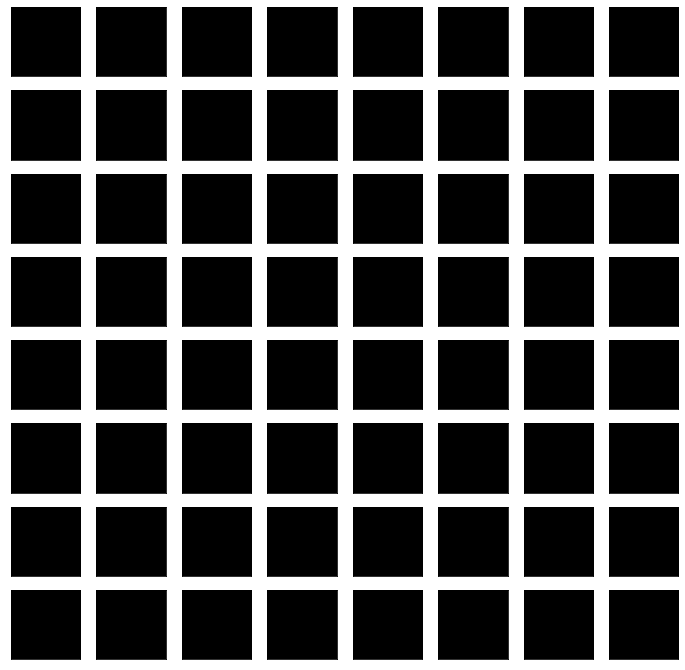

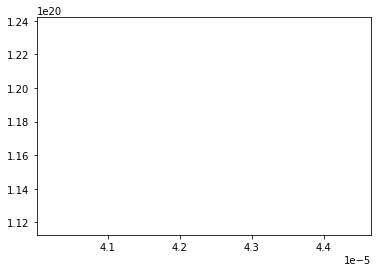

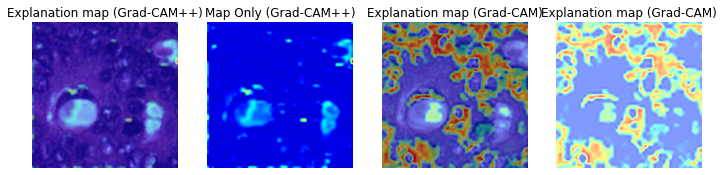

In [ ]:
#@title Grad-CAM++

index=np.random.randint(0,len(image_batch))
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

import keras.layers.core

#def grad_cam_pp(input_model,image,layer_name):
input_model = model
image = np.expand_dims(image_batch[index],axis=0)
layer_name = 'max_pooling2d_1'
cls_probs = input_model.predict(image)
cls = np.argmax(cls_probs)
n_cls = cls_probs.shape[1]

"""GradCAM method for visualizing input saliency."""
y_c = input_model.output
conv_output = input_model.get_layer(layer_name).output
feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
with tf.GradientTape(persistent=True) as tape:
  ff_results=feedforward1([image])
  all_fmap_masks, predictions = ff_results[0], ff_results[-1]
  loss = predictions[:, cls]
  grads_val1 = tape.gradient(loss, all_fmap_masks)
  grads_val2 = tape.gradient(grads_val1,all_fmap_masks)
grads_val3 = tape.gradient(grads_val2,all_fmap_masks)
if len(image.shape)==3:
    axis=(0, 1)
elif len(image.shape)==4:
    axis=(0, 1, 2)
alpha_num = grads_val2
alpha_denom = 2*grads_val2 + np.sum(all_fmap_masks,axis=axis)*grads_val3
#print(grads_val2)
weights = np.sum(tf.nn.relu(grads_val1)*alpha_num/alpha_denom, axis=axis)
plot_maps(alpha_denom[0,:,:].numpy(),64)
plot_kde(alpha_num[0,:,:,0].numpy(),0.25)
weights = np.nan_to_num(weights)
cam = np.dot(all_fmap_masks[0], weights)
#print (cam)
H,W= image.shape[1:3]
cam = np.maximum(cam, 0)
#cam = resize(cam, (H, W))
cam = zoom(cam,H/cam.shape[0])
#cam = np.maximum(cam, 0)
cam = cam / cam.max()
#return cam
conv_layer = 'max_pooling2d_1'
map_gradcampp = cam
#map_gradcampp = grad_cam_pp(model,np.expand_dims(image_batch[index],axis=0),conv_layer)
map_gradcampp -= map_gradcampp.min()
map_gradcampp /= map_gradcampp.max() + np.finfo(np.double).eps
plt.figure(figsize=[12,8])
plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.imshow(map_gradcampp, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM++)')

plt.subplot(1,4,2)
plt.imshow(map_gradcampp, cmap='jet')
plt.axis('off')
plt.title('Map Only (Grad-CAM++)')

explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+np.finfo(np.double).eps

plt.subplot(1,4,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,4,4)
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')


Text(0.5, 1.0, 'Explanation map (RISE)')

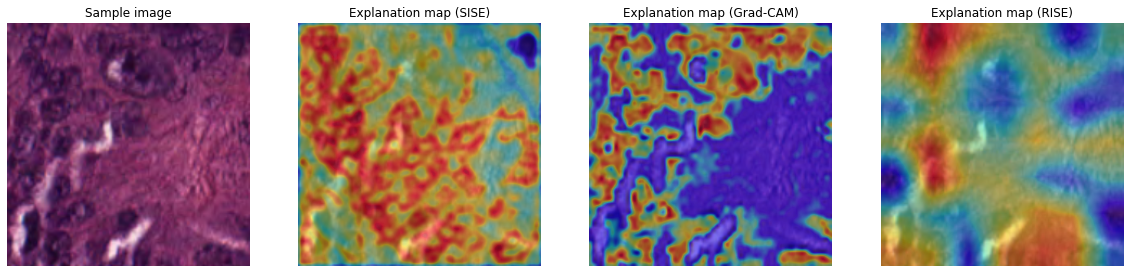

In [ ]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,4,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,4,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,4,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

## Quantitative evaluation of the explanation algorithm

In [31]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [32]:
def calculateDropRateGradCAMPP():
  test_generator.reset()
  drop_rate = 0.
  for _ in range(15):
      image_batch,label_batch=test_generator.next()
      for index in range(32):
          prediction=model(image_batch)
          explanation_map_gradcam_pp = grad_cam_pp_ygrad(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
          #explanation_map_SISE = method(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
          drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_gradcam_pp, class_index=np.argmax(prediction[index]), frac=0.9)[0]
  drop_rate /= (15*32)
  return drop_rate
drop_rate = calculateDropRateGradCAMPP()